# Question 1- Clustering Problem


___
___
Future Datathon

Author: Akhil Punia  

Date: 27-11-2017 
___

1. I have removed the redundant features like product and store description and converted datetime features to years and days. 
2. Variable such as 'discountUsed' is converted into six independent features for better representation of inherent knowledge in the labels.
3. Feature cleaning is done in 'State' variable to remove its inherent redundancy.
4. Feature correlation is done to check the independence of scaled features.
5. KMeans clustering with an optimal value of n=4 is performed on the dataset. 
6. I have tried to visualise the performance of clustering by using tsne to map the data points into a two dimensional space.
7. In the end, I have tried to cluster points based on feature reduced space from TSNE.
8. It has beeen found that for Stores '3692' & '4796', the optimal value of n is 3.

In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from tqdm import tqdm
from sklearn.metrics import silhouette_score as silhouette
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from utils import trans_date, trans_str, trans_state, trans_lblencode,fixDiscounts

___
___

## I. Importing & Visualising
___

In [5]:
## load data
products = pd.read_csv('./data1/cproducts.csv')
tender = pd.read_csv('./data1/ctender.csv')

In [6]:
## check shape of files
print('product file has {} rows and {} columns'.format(products.shape[0], products.shape[1]))
print('tender file has {} rows and {} columns'.format(tender.shape[0], tender.shape[1]))

product file has 11972 rows and 16 columns
tender file has 149752 rows and 13 columns


In [7]:
# this data file contains product level information of transactions made by customers
products.head()

,customerID,DOB,Gender,State,PinCode,transactionDate,store_code,store_description,till_no,transaction_number_by_till,promo_code,promotion_description,product_code,product_description,sale_price_after_promo,discountUsed
0,BBID_20482,1975-10-20,male,MADHYA PRADESH,453441,2016-05-01,2655,BB-INDORE-MALHAR MEGA MALL,2,85246,NONPROMO,NaN,1000446431,PATANJALI CHOCOS 125g,55.00,Payback
1,BBID_20485,1955-07-21,female,NaN,999999,2017-03-09,2655,BB-INDORE-MALHAR MEGA MALL,8,78829,NONPROMO,NaN,1000010431,SOO FRESH ROLLS HOT DOG 4P,30.00,Payback
2,BBID_20498,1981-03-19,female,MAHARASHTRA,400064,2015-08-12,2655,BB-INDORE-MALHAR MEGA MALL,13,1064,0000971754,AD 399 FLAT LADIES JEANS FASHION EXC,1000077851005,"DLJ-0010-BSF-2-CJ-FL, 34, BLACK",418.95,Payback
3,BBID_20499,1986-05-10,male,MAHARASHTRA,400099,2016-12-18,2615,BB-AMRITSAR-TRILIUM MALL,14,51080,NONPROMO,NaN,1000443231,PATANJALI TOMATO KETCHUP BT 500g,70.00,Payback
4,BBID_204110,1988-02-29,male,MADHYA PRADESH,474001,2015-12-31,2655,BB-INDORE-MALHAR MEGA MALL,9,21911,0000974126,NMP 5% OFF CONCEPT DISCOUNT 2655,300481741,MAGGI NDL MERI MASALA PP 70g,34.20,Payback


In [8]:
products.isnull().sum()

customerID                       0
DOB                            319
Gender                        1028
State                         1583
PinCode                        817
transactionDate                  0
store_code                       0
store_description                0
till_no                          0
transaction_number_by_till       0
promo_code                       0
promotion_description         8510
product_code                     0
product_description              0
sale_price_after_promo           0
discountUsed                     0
dtype: int64

___
___

## II. Feature Cleaning

____

In [9]:
products['discountUsed'].unique()

array(['Payback', 'BBProfitClub', 'BBProfitClub,Payback',
       'T24Club,Payback', 'T24Club,BBProfitClub',
       'T24Club,BBProfitClub,Payback', 'FGShoppingFest',
       'FGShoppingFest,T24Club', 'FGShoppingFest,T24Club,Payback',
       'FGShoppingFest,Payback', 'FGShoppingFest,BBProfitClub',
       'FGShoppingFest,T24Club,BBProfitClub,Payback',
       'FGShoppingFest,BBProfitClub,Payback',
       'FGShoppingFest,T24Club,BBProfitClub',
       'FuturePrivilegeClub,FGShoppingFest', 'FuturePrivilegeClub,Payback',
       'FuturePrivilegeClub,BBProfitClub', 'BBSavingsClub',
       'BBSavingsClub,Payback', 'BBSavingsClub,BBProfitClub,Payback',
       'BBSavingsClub,BBProfitClub', 'BBSavingsClub,T24Club,Payback',
       'BBSavingsClub,T24Club', 'FuturePrivilegeClub,T24Club,BBProfitClub',
       'FuturePrivilegeClub,T24Club,Payback',
       'FuturePrivilegeClub,T24Club,BBProfitClub,Payback',
       'BBSavingsClub,T24Club,BBProfitClub',
       'BBSavingsClub,T24Club,BBProfitClub,Payback'], dt

> We see that, we have only 6 unique discount coupons. Rest are made up of the the several combinations of the same.
- Payback
- BBProfitClub
- T24Club
- FGShoppingFest
- FuturePrivilegeClub
- BBSavingsClub

In [10]:
products= fixDiscounts(products);

utils.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
utils.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
utils.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
utils.py:125: SettingWithCopyWarning: 
A value is trying to be set on a 

utils.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
utils.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
utils.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
utils.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
utils.py:167: SettingWithCopyWarning: 
A value is trying to be set on a 

In [11]:
products.tail(10)

,customerID,DOB,Gender,State,PinCode,transactionDate,store_code,store_description,till_no,transaction_number_by_till,...,product_code,product_description,sale_price_after_promo,discountUsed,Payback,BBProfitClub,T24Club,FGShoppingFest,FuturePrivilegeClub,BBSavingsClub
11962,BBID_211461241,1980-07-22,male,KARNATAKA,580030,2017-05-21,4796,BB-HUBLI-GOKUL ROAD-AKSHAY CEN,6,19374,...,108015369,SCOTCH BRI UTENSL SRB SUP SAVER,36.00,"BBSavingsClub,T24Club,Payback",1,0,1,0,0,1
11963,BBID_211461325,1978-12-08,male,JHARKHAND,831012,2017-05-14,4843,BB-JAMSHEDPUR-NH-33,23,88484,...,108003202,EVEREST POW SPICE BLACK PEPPER BX 100g,157.50,BBSavingsClub,0,0,0,0,0,1
11964,BBID_211461371,1971-01-06,male,JHARKHAND,831003,2017-05-11,4843,BB-JAMSHEDPUR-NH-33,9,66629,...,108018298,ACT II H&E MWPC BUTTER LOVERS 99g,189.00,"BBSavingsClub,Payback",1,0,0,0,0,1
11965,BBID_211461372,1956-04-26,male,JHARKHAND,831012,2017-05-11,4843,BB-JAMSHEDPUR-NH-33,9,66638,...,1000510572,COLGATE TBRUSH SENSITIVE ULTRA SOFT 2+1,88.20,BBSavingsClub,0,0,0,0,0,1
11966,BBID_211461387,1973-02-03,male,JHARKHAND,831018,2017-05-17,4843,BB-JAMSHEDPUR-NH-33,23,89115,...,1000069942,BISK FARM SLT BIS NAMKEENZ JR 200g,36.00,"BBSavingsClub,Payback",1,0,0,0,0,1
11967,BBID_211461439,1973-04-18,male,JHARKHAND,831012,2017-06-06,4843,BB-JAMSHEDPUR-NH-33,9,72096,...,108037568,SUGAR MEDIUM LOOSE,90.81,"BBSavingsClub,T24Club,BBProfitClub,Payback",1,0,1,0,0,1
11968,BBID_211461453,1994-12-10,female,JHARKHAND,831018,2017-04-19,4843,BB-JAMSHEDPUR-NH-33,3,90594,...,1000724195003,"VIP Pulse SP Blue, 81 cm",4756.50,BBSavingsClub,0,0,0,0,0,1
11969,BBID_211461466,1959-08-25,female,JHARKHAND,832401,2017-04-17,4843,BB-JAMSHEDPUR-NH-33,5,6628,...,300196348,CLMT PHENYLS MILKY 2*1L,89.10,"BBSavingsClub,Payback",1,0,0,0,0,1
11970,BBID_211461471,1955-01-01,NaN,JHARKHAND,831018,2017-06-12,4843,BB-JAMSHEDPUR-NH-33,5,22026,...,108035243,TATA CTC TEA GOLD PP 250g,90.90,BBSavingsClub,0,0,0,0,0,1
11971,BBID_211461472,1985-01-01,male,JHARKHAND,831019,2017-05-22,4843,BB-JAMSHEDPUR-NH-33,9,68822,...,1000117614,BOILED SWEET CORN PERI PERI MASALA,63.00,BBSavingsClub,0,0,0,0,0,1


In [12]:
products = trans_state(products)
tender = trans_state(tender)

In [13]:
products = trans_date(products)
tender = trans_date(tender)

In [14]:
## fill missing values
products['promotion_description'].fillna('no_promo', inplace=True)
products['Gender'].fillna('no_gender', inplace=True)
products['State'].fillna('no_state', inplace=True)
products['PinCode'].fillna(-1, inplace=True)

tender['PaymentUsed'].fillna('missing', inplace=True)
tender['Gender'].fillna('no_gender', inplace=True)
tender['State'].fillna('no_state', inplace=True)
tender['PinCode'].fillna(-1, inplace=True)

In [15]:
products = trans_str(products)
products = trans_lblencode(products)

In [16]:
products.head()

,customerID,DOB,Gender,State,PinCode,transactionDate,store_code,store_description,till_no,transaction_number_by_till,...,product_code,product_description,sale_price_after_promo,discountUsed,Payback,BBProfitClub,T24Club,FGShoppingFest,FuturePrivilegeClub,BBSavingsClub
0,BBID_20482,42,1,16,449,18,2655,BB-INDORE-MALHAR MEGA MALL,2,85246,...,1000446431,4269,55.00,24,1,0,0,0,0,0
1,BBID_20485,62,0,27,1353,8,2655,BB-INDORE-MALHAR MEGA MALL,8,78829,...,1000010431,5121,30.00,24,1,0,0,0,0,0
2,BBID_20498,36,0,14,288,27,2655,BB-INDORE-MALHAR MEGA MALL,13,1064,...,1000077851005,1617,418.95,24,1,0,0,0,0,0
3,BBID_20499,31,1,14,305,11,2615,BB-AMRITSAR-TRILIUM MALL,14,51080,...,1000443231,4364,70.00,24,1,0,0,0,0,0
4,BBID_204110,29,1,16,529,22,2655,BB-INDORE-MALHAR MEGA MALL,9,21911,...,300481741,3472,34.20,24,1,0,0,0,0,0


___
___

## III. Useful Variable Statistics 
___

In [17]:
print products['promo_code'].unique()
print len(products['promo_code'].unique())

[2213  216  225 ..., 1879 1839 2212]
2214


In [18]:
print products['till_no'].unique()
print len(products['till_no'].unique())

[ 2  8 13 14  9  4 11  5 10  1 18 16  6 20 12  7 19 15  3 22 25 17 21 23 24]
25


In [19]:
print products['transaction_number_by_till'].unique()
print len(products['transaction_number_by_till'].unique())

[85246 78829  1064 ...,  6628 22026 68822]
11127


In [20]:
products.drop(['store_description','promotion_description','discountUsed','product_description','transaction_number_by_till'], axis=1, inplace=True)

In [21]:
products.head()

,customerID,DOB,Gender,State,PinCode,transactionDate,store_code,till_no,promo_code,product_code,sale_price_after_promo,Payback,BBProfitClub,T24Club,FGShoppingFest,FuturePrivilegeClub,BBSavingsClub
0,BBID_20482,42,1,16,449,18,2655,2,2213,1000446431,55.00,1,0,0,0,0,0
1,BBID_20485,62,0,27,1353,8,2655,8,2213,1000010431,30.00,1,0,0,0,0,0
2,BBID_20498,36,0,14,288,27,2655,13,216,1000077851005,418.95,1,0,0,0,0,0
3,BBID_20499,31,1,14,305,11,2615,14,2213,1000443231,70.00,1,0,0,0,0,0
4,BBID_204110,29,1,16,529,22,2655,9,225,300481741,34.20,1,0,0,0,0,0


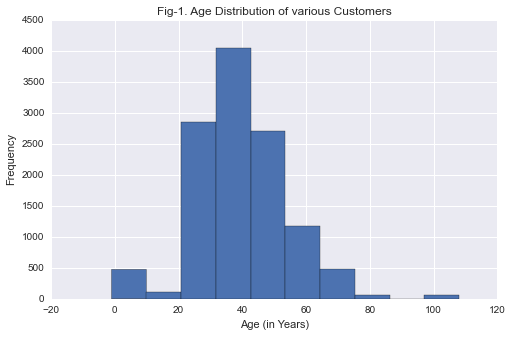

In [22]:
plt.figure(figsize=(8,5))
products['DOB'].hist()
plt.title('Fig-1. Age Distribution of various Customers')
plt.xlabel('Age (in Years)')
plt.ylabel('Frequency')

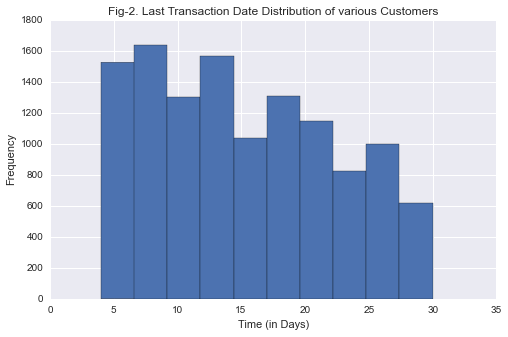

In [23]:
plt.figure(figsize=(8,5))
products['transactionDate'].hist()
plt.title('Fig-2. Last Transaction Date Distribution of various Customers')
plt.xlabel('Time (in Days)')
plt.ylabel('Frequency')

/Users/akhilpunia/anaconda/envs/py27/lib/python2.7/site-packages/pandas/tools/plotting.py:2633: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  warnings.warn(msg, FutureWarning)


(array([1]), <a list of 1 Text xticklabel objects>)

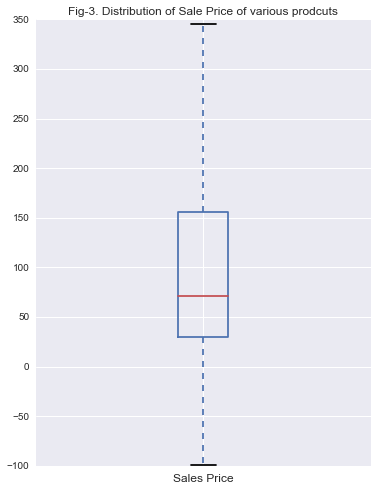

In [24]:
plt.figure(figsize=(6,8))
p = pd.DataFrame({'Sales Price':list(products['sale_price_after_promo'])})
p.boxplot(showfliers=False)
plt.title('Fig-3. Distribution of Sale Price of various prodcuts')
plt.xticks(rotation =0)

In [25]:
pro_code = [str(products['product_code'][i]) for i in range(len(products))]
products['product_code'] = pro_code

In [26]:
products = trans_lblencode(products)

In [27]:
products.head()

,customerID,DOB,Gender,State,PinCode,transactionDate,store_code,till_no,promo_code,product_code,sale_price_after_promo,Payback,BBProfitClub,T24Club,FGShoppingFest,FuturePrivilegeClub,BBSavingsClub
0,BBID_20482,42,1,16,449,18,2655,2,2213,1750,55.00,1,0,0,0,0,0
1,BBID_20485,62,0,27,1353,8,2655,8,2213,45,30.00,1,0,0,0,0,0
2,BBID_20498,36,0,14,288,27,2655,13,216,395,418.95,1,0,0,0,0,0
3,BBID_20499,31,1,14,305,11,2615,14,2213,1708,70.00,1,0,0,0,0,0
4,BBID_204110,29,1,16,529,22,2655,9,225,4816,34.20,1,0,0,0,0,0


In [28]:
pcopy = products.copy()

In [29]:
pcopy.head()

,customerID,DOB,Gender,State,PinCode,transactionDate,store_code,till_no,promo_code,product_code,sale_price_after_promo,Payback,BBProfitClub,T24Club,FGShoppingFest,FuturePrivilegeClub,BBSavingsClub
0,BBID_20482,42,1,16,449,18,2655,2,2213,1750,55.00,1,0,0,0,0,0
1,BBID_20485,62,0,27,1353,8,2655,8,2213,45,30.00,1,0,0,0,0,0
2,BBID_20498,36,0,14,288,27,2655,13,216,395,418.95,1,0,0,0,0,0
3,BBID_20499,31,1,14,305,11,2615,14,2213,1708,70.00,1,0,0,0,0,0
4,BBID_204110,29,1,16,529,22,2655,9,225,4816,34.20,1,0,0,0,0,0


### Plotting Feature Correlation Map

In [30]:
pcopy.drop(['customerID','store_code'],axis=1,inplace=True)

In [31]:
sc = StandardScaler()
data = sc.fit_transform(pcopy)

In [32]:
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr,
        cmap = cmap,
        square=True,
        cbar_kws={ 'shrink' : .9 },
        ax=ax,
        annot = True,
        annot_kws = { 'fontsize' : 12 }
    )

In [33]:
cols = pcopy.columns

In [34]:
for i,c in enumerate(cols):
    pcopy[c] = data[:,i]

/Users/akhilpunia/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


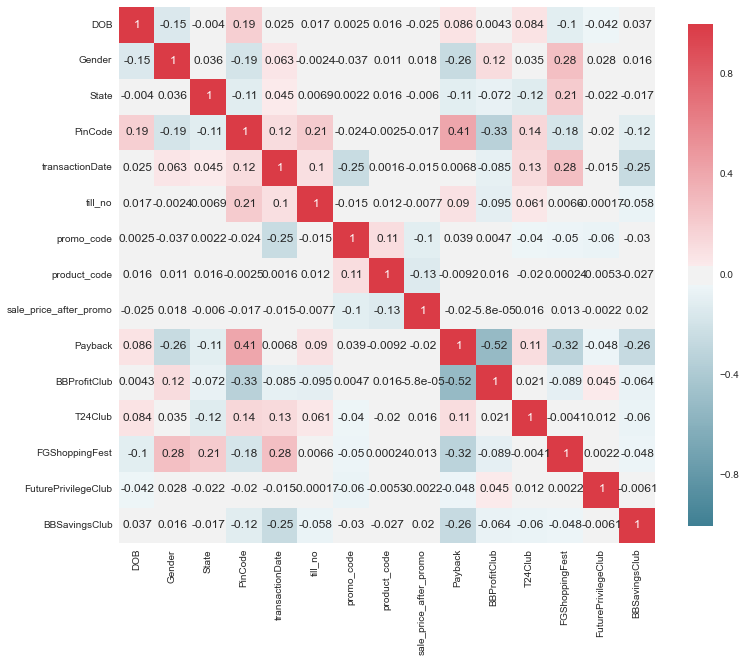

In [35]:
plot_correlation_map(pcopy)

___

### Note:
Let's build a simple model using products file only. We have to create clusters of customers at store level. We'll use k-means algorithm. We'll set value of k as 3 (you can tune and find optimal value)

Clustering process is as follows (work-wise):
1. Convert the data into numeric / float.
2. Since clustering using distance measure, don't forget to scale the data. 
3. Create a matrix /array which will be feeded to the algorithm.
4. Run function.

We'll ensure that sequence of data remains unaffected. Let's see how this is done.

___
____

## IV. Clustering
___

We are clustering our customers for (7) Seven Stores.
- 0 [BB-AMRITSAR-TRILIUM MALL]
- 1 [BB-INDORE-MALHAR MEGA MALL]
- 2 [BB-INDORE-TREASURE ISLAND]
- 3 [BB-LUDHIANA-FEROZEPUR-MF]
- 4 [BB-HUBLI-GOKUL ROAD-AKSHAY CEN]
- 5 [BB-JAMSHEDPUR-NH-33]
- 6 [BB-MADURAI-KOCHADAI VILLAGE]


In [34]:
set(products['store_code'])

{'2615', '2655', '2906', '3692', '4796', '4843', '4986'}

In [35]:
## scaling, creating matrix and running k-means

stores = list(set(products['store_code']))

cluster_labels = []
cluster_store = []
cluster_data = []
cluster_customers = []
cluster_score = []

for x in stores:
    cld = products[products['store_code'] == x]
    cluster_customers.append(cld['customerID'])
    cld.drop(['store_code','customerID'], axis=1, inplace=True)
    
    rbs = RobustScaler()
    cld2 = rbs.fit_transform(cld)
    
    km1 = KMeans(n_clusters=4) # Optimal value chosen after various performance.
    km2 = km1.fit(cld2)
    label = km2.predict(cld2)
    
    s_score = silhouette_score(cld2, label)
    cluster_score.append(s_score)
    
    cluster_labels.append(label)
    cluster_store.append(np.repeat(x, cld.shape[0]))
    cluster_data.append(cld2)

/Users/akhilpunia/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [36]:
# check mean score per store
np.mean(cluster_score)

0.74766900640073897

In [37]:
## merge list into ndarray
cluster_data = np.concatenate(cluster_data)

In [38]:
## check if the array has same rows as products file - Yes!
cluster_data.shape

(11972, 15)

In [39]:
## convert nested lists as 1d array
cluster_customers = np.concatenate(cluster_customers)
cluster_store = np.concatenate(cluster_store)
cluster_labels = np.concatenate(cluster_labels)

In [40]:
## create submission files
sub1 = pd.DataFrame({'customerID':cluster_customers, 'store_code':cluster_store, 'cluster':cluster_labels})

In [41]:
np.savetxt('../subOne_18.txt', cluster_data)
sub1.to_csv('../subtwo_18.csv', index=False)

### Score ~ 0.71396

___
___

### V. Visualising the Clusters using TSNE
___

In [36]:
import time
from ggplot import *
from sklearn.manifold import TSNE

def cluster(x,n):
    n_sne = 7000
    cld = products[products['store_code'] == x]  # Store Code : 0
    cld.drop(['store_code','customerID'], axis=1, inplace=True)
    rbs = RobustScaler()
    cld2 = rbs.fit_transform(cld)

    km1 = KMeans(n_clusters=n)
    km2 = km1.fit(cld2)
    label = km2.predict(cld2)

    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(cld2)

    print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)

    df_tsne = pd.DataFrame({'Label':label})
    df_tsne['x-tsne'] = tsne_results[:,0]
    df_tsne['y-tsne'] = tsne_results[:,1]
    plt.figure(figsize=(10,15))
    
    chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
            + geom_point(size=70,alpha=0.1) \
            + ggtitle("tSNE dimensions colored by digit")
    plt.show()
    s_score = silhouette_score(cld2, label)
    print "Silhoutte Score for",i+1," Cluster: ",s_score
    return chart

/Users/akhilpunia/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 723 samples in 0.001s...
[t-SNE] Computed neighbors for 723 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 723 / 723
[t-SNE] Mean sigma: 0.910592
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.500343
[t-SNE] Error after 300 iterations: 0.748388
t-SNE done! Time elapsed: 7.15935897827 seconds


Silhoutte Score for 15  Cluster:  0.883174160983


/Users/akhilpunia/anaconda/envs/py27/lib/python2.7/site-packages/ggplot/ggplot.py:192: RuntimeWarning: Setting "mpl.rcParams['axes.prop_cycle']=cycler(u'color', [u'#333333', u'#348ABD', u'#7A68A6', u'#A60628', u'#467821', u'#CF4457', u'#188487', u'#E24A33'])" raised an Exception: u'axes.prop_cycle is not a valid rc parameter.See rcParams.keys() for a list of valid parameters.'
  warnings.warn(msg, RuntimeWarning)


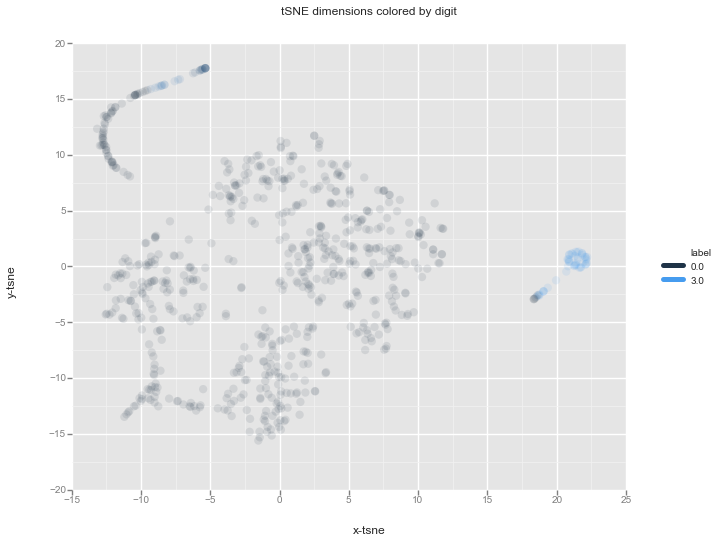

<ggplot: (292342629)>

In [37]:
cluster('2615',4)

/Users/akhilpunia/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2767 samples in 0.008s...
[t-SNE] Computed neighbors for 2767 samples in 0.199s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2767
[t-SNE] Computed conditional probabilities for sample 2000 / 2767
[t-SNE] Computed conditional probabilities for sample 2767 / 2767
[t-SNE] Mean sigma: 0.891597
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.007774
[t-SNE] Error after 300 iterations: 1.174684
t-SNE done! Time elapsed: 27.4084157944 seconds


Silhoutte Score for 15  Cluster:  0.853080627173


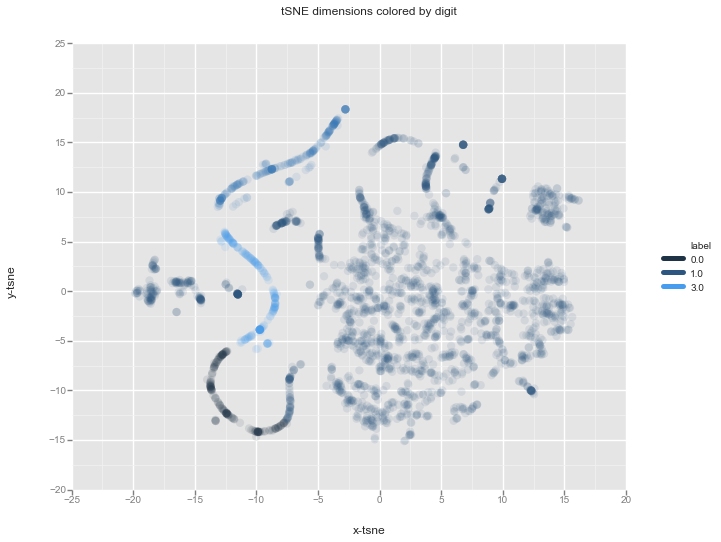

<ggplot: (292315817)>

In [40]:
cluster('2655',4)

/Users/akhilpunia/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1257 samples in 0.002s...
[t-SNE] Computed neighbors for 1257 samples in 0.094s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1257
[t-SNE] Computed conditional probabilities for sample 1257 / 1257
[t-SNE] Mean sigma: 0.949005
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.769150
[t-SNE] Error after 300 iterations: 0.810261
t-SNE done! Time elapsed: 11.5923550129 seconds


Silhoutte Score for 15  Cluster:  0.859706329448


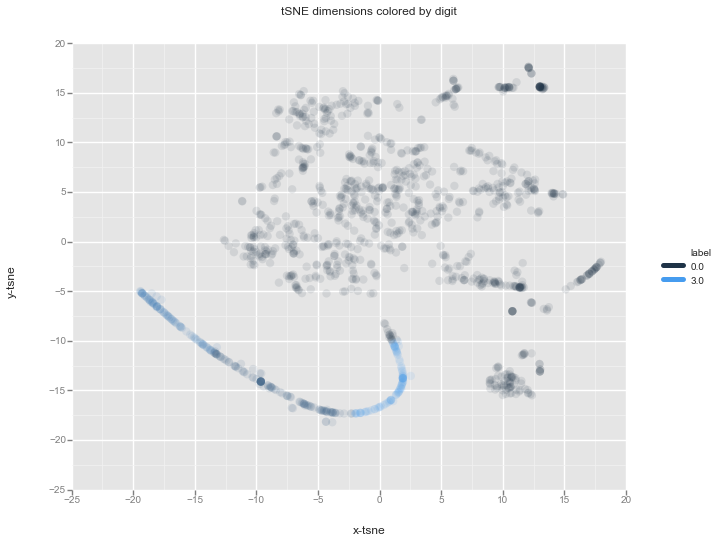

<ggplot: (288996881)>

In [41]:
cluster('2906',4)

/Users/akhilpunia/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 574 samples in 0.001s...
[t-SNE] Computed neighbors for 574 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 574 / 574
[t-SNE] Mean sigma: 1.071227
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.200447
[t-SNE] Error after 300 iterations: 0.804912
t-SNE done! Time elapsed: 6.18718504906 seconds


Silhoutte Score for 15  Cluster:  0.893657945272


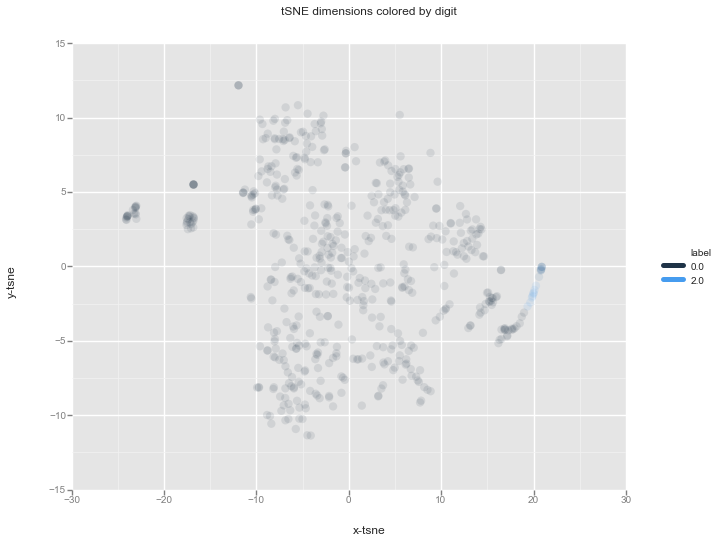

<ggplot: (292300349)>

In [42]:
cluster('3692',3)

/Users/akhilpunia/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2768 samples in 0.002s...
[t-SNE] Computed neighbors for 2768 samples in 0.288s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2768
[t-SNE] Computed conditional probabilities for sample 2000 / 2768
[t-SNE] Computed conditional probabilities for sample 2768 / 2768
[t-SNE] Mean sigma: 0.814010
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.626518
[t-SNE] Error after 300 iterations: 1.304293
t-SNE done! Time elapsed: 31.6154708862 seconds


Silhoutte Score for 15  Cluster:  0.824735497457


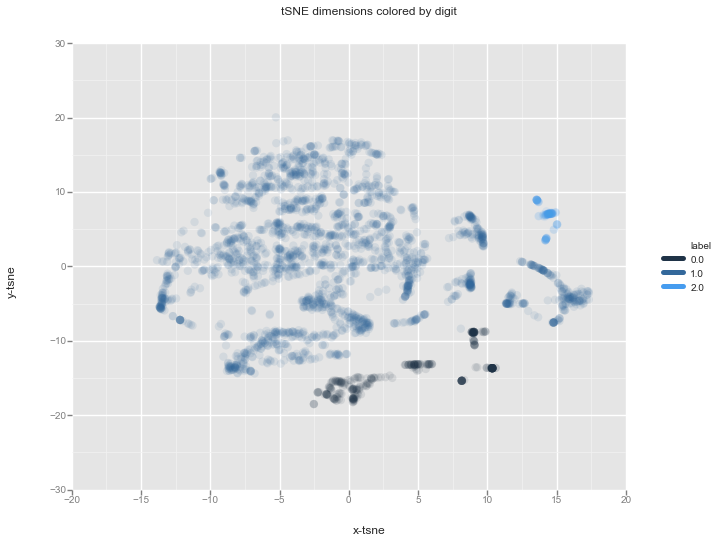

<ggplot: (289251789)>

In [43]:
cluster('4796',3)

/Users/akhilpunia/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2135 samples in 0.002s...
[t-SNE] Computed neighbors for 2135 samples in 0.160s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2135
[t-SNE] Computed conditional probabilities for sample 2000 / 2135
[t-SNE] Computed conditional probabilities for sample 2135 / 2135
[t-SNE] Mean sigma: 0.831399
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.442657
[t-SNE] Error after 300 iterations: 1.166413
t-SNE done! Time elapsed: 24.0134758949 seconds


Silhoutte Score for 15  Cluster:  0.734084171655


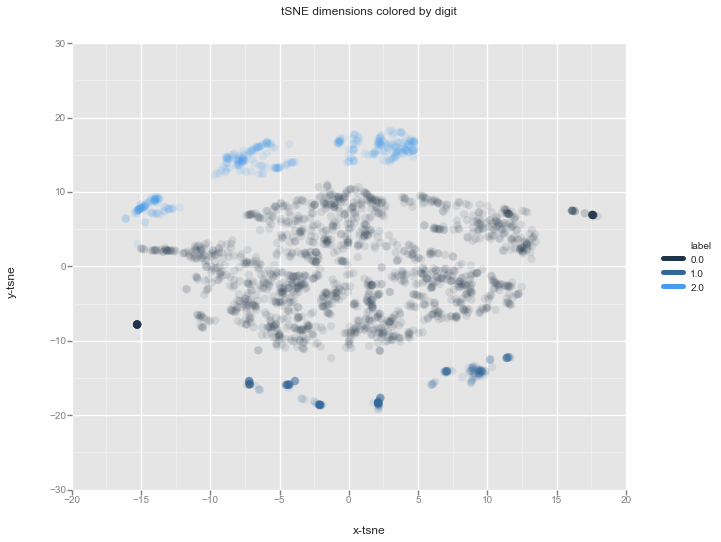

<ggplot: (288449913)>

In [44]:
cluster('4843',3)

/Users/akhilpunia/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1748 samples in 0.002s...
[t-SNE] Computed neighbors for 1748 samples in 0.114s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1748
[t-SNE] Computed conditional probabilities for sample 1748 / 1748
[t-SNE] Mean sigma: 0.840918
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.929317
[t-SNE] Error after 300 iterations: 1.076048
t-SNE done! Time elapsed: 16.7163820267 seconds


Silhoutte Score for 15  Cluster:  0.721932171888


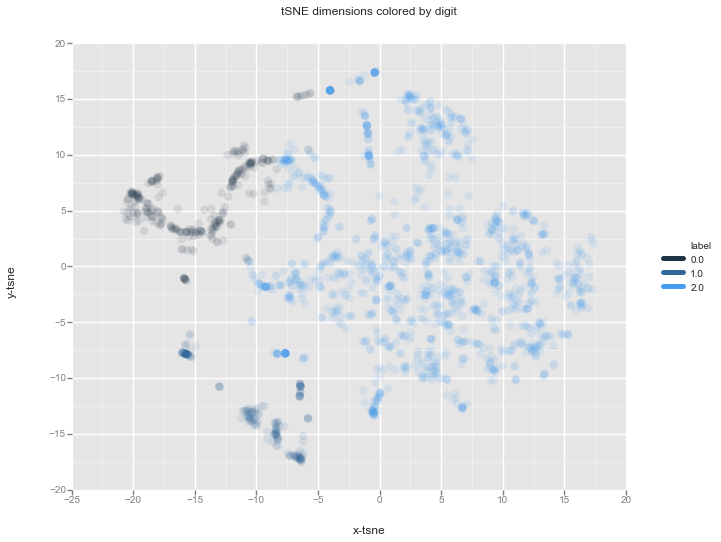

<ggplot: (289658873)>

In [45]:
cluster('4986',3)

## Clustering Performance 

| Store ID | **Silhoutte Score (@ n=4) **| **Silhoutte Score (@ n=3) **|
|----------|-----------------------------|-----------------------------|
|   2615   |    0.883174160983           |                             |
|   2655   |    0.853075945795           |                             |
|   2906   |    0.859706329448           |                             |
|   3692   |    0.631942686238           |    0.893657945272           |
|   4796   |    0.564118419298           |    0.824735497457           |
|   4843   |    0.719897835032           |    0.734084171655           |
|   4986   |    0.721960268629           |    0.721932171888           |

___
___

### Clustering by reducing the Dimensions by Feature Space using tSNE

___

In [54]:
cld = products[products['store_code'] == '2615']  # Store Code : 2615
cld.drop(['store_code','customerID'], axis=1, inplace=True)
rbs = RobustScaler()
cld2 = rbs.fit_transform(cld)

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=600)
tsne_results = tsne.fit_transform(cld2)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 723 samples in 0.001s...
[t-SNE] Computed neighbors for 723 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 723 / 723
[t-SNE] Mean sigma: 0.910592


/Users/akhilpunia/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.078640
[t-SNE] Error after 600 iterations: 0.704527


In [55]:
km1 = KMeans(n_clusters=4)
km2 = km1.fit(tsne_results)
label = km2.predict(tsne_results)

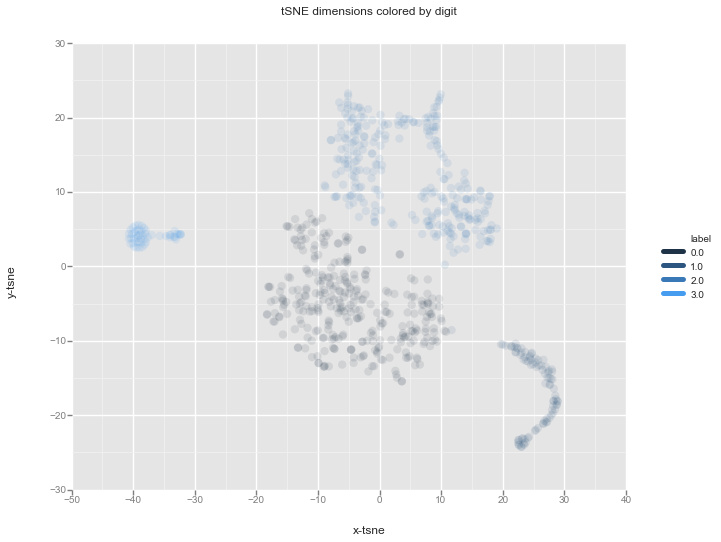

<ggplot: (283415597)>

In [56]:
df_tsne = pd.DataFrame({'Label':label})
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]
plt.figure(figsize=(10,15))

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")

chart

In [57]:
s_score = silhouette_score(cld2, label)

In [58]:
s_score

0.10112394221171804